In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
dataPath = "./data/"

train = pd.read_csv(dataPath + 'train.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


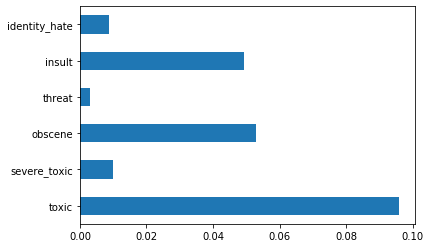

In [3]:
train[types].mean().plot(kind='barh')

In [4]:
test = pd.read_csv(dataPath+'test.csv',index_col=0)
test_labels = pd.read_csv(dataPath+'test_labels.csv',index_col=0)
print(test_labels.head())
labelled_test = test.join(test_labels)
disclosed = labelled_test.toxic>-1
print(disclosed .mean(),'% of test is labelled')
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]
print(train.shape,test.shape)
train.to_csv(dataPath+'tc_train.csv')
test.to_csv(dataPath+'tc_test.csv')

                  toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1
0.41770912224804785 % of test is labelled
(223549, 7) (89186, 1)


In [5]:
train = pd.read_csv(dataPath + 'tc_train.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test = pd.read_csv(dataPath + 'tc_test.csv',index_col=0)
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


# Get Embeddings

In [7]:
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            # remove white spaces and split
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index

In [8]:
embeddings_index = get_embeddings('crawl-300d-2M.vec')

# Preprocess Text

In [9]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

# Create Vocabulary

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

train['comment_text'] = train.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train.comment_text)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
45259 top words


In [11]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['upa', 'designed', 'dozen', 'bcs', 'huddersfield', 'lubbock', 'jfdwolff', 'ein', 'pico', 'dekker']

Is "unknown" in top_words? 
 True


# Tokenization

In [12]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

Using TensorFlow backend.


In [13]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train.comment_text)
print(tokenizer)

In [14]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

280518


[('the', 1),
 ('to', 2),
 ('of', 3),
 ('and', 4),
 ('a', 5),
 ('you', 6),
 ('i', 7),
 ('is', 8),
 ('that', 9),
 ('in', 10),
 ('it', 11),
 ('for', 12),
 ('this', 13),
 ('not', 14),
 ('on', 15),
 ('be', 16)]

# Input data for Network

Prepare input data for neural network.

In [15]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train.comment_text)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'toxic_data.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[676, 77, 1, 133, 130, 177, 30, 666, 4436, 11406, 1126, 85, 349, 51, 2184, 12587, 50, 6354, 15, 59, 2567, 148, 7, 2795, 33, 116, 1196, 15967, 2453, 4, 47, 60, 247, 1, 359, 31, 1, 41, 27, 143, 71, 3503, 89], [121402, 52, 2765, 13, 466, 3656, 71, 4530, 2696, 21, 93, 41, 968, 196]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  676    77     1   133   130   177    30   666  4436 11406  1126    85
   349    51  2184 12587    50  6354    15    59  2567   148     7  2795
    33   116  1196 15967  2453     4    47    60   247     1   359    31
     1    41    27   143    71  3503    89     0     0     0     0     0
     0     0]


In [16]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


In [17]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [18]:
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [19]:
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = dataPath + 'toxic_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

160113 unknown words


# Split into new train and validation sets


In [20]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [21]:
import pickle
from sklearn.model_selection import train_test_split

# convert each vector of labels to the string
labels = train[types].astype(str).apply(lambda x: ''.join(x),axis=1)
print('Labels: \n',labels.head())
# aggregate rare combinations if any
count = labels.value_counts()
rare = count.index[count<=2]
labels[np.isin(labels.values,rare)] = 'rare'
print('\nCounts of labels: \n',labels.value_counts())
train_index, val_index = train_test_split(list(range(data.shape[0])), test_size=0.2, 
                                      stratify = labels, random_state=0)
# save train and validation indices for further calculations
fname = dataPath + 'train_val_split.pkl'
with open(fname, 'wb') as f: pickle.dump([train_index, val_index], f, -1),

Labels: 
 id
0000997932d777bf    000000
000103f0d9cfb60f    000000
000113f07ec002fd    000000
0001b41b1c6bb37e    000000
0001d958c54c6e35    000000
dtype: object

Counts of labels: 
 000000    201081
100000      7376
101010      5732
101000      2612
100010      1754
111010      1165
101011       979
111011       381
001000       366
000010       365
100011       215
100001       203
001010       196
101110       196
111000       186
100100       163
111110        88
101111        81
000001        68
101001        55
111111        45
110000        41
000011        32
000100        27
100110        25
001011        19
101100        17
110010        14
110100        11
100101        11
111100         8
111001         7
110011         7
110101         5
rare           5
000110         4
100111         3
110001         3
001001         3
dtype: int64


In [22]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)
with open(dataPath + 'toxic_data.pkl', 'rb') as f: data = pickle.load(f)   



In [23]:
X_train = data[train_index]
X_test = data[val_index]

y_train = train.iloc[train_index][['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
y_test = train.iloc[val_index][['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

# Neural Network

In [24]:
from keras.layers import Dense,Embedding,Input,Dropout,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, Flatten,LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from keras.utils import plot_model


def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(10, return_sequences=True)(x)
    x = Conv1D(5, kernel_size=2, padding="valid")(x)
    x = GlobalMaxPooling1D()(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=Adam())
    return model

In [25]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
plot_model(model, to_file='toxic_comments.png',show_shapes=True,show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           84155700  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 10)            12440     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 5)             105       
_________________________________________________________________
global_max_pooling1d_

In [26]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=28, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 178839 samples, validate on 44710 samples
Epoch 1/28
 - 60s - loss: 0.5660 - val_loss: 0.2996
Epoch 2/28
 - 53s - loss: 0.2135 - val_loss: 0.1078
Epoch 3/28
 - 52s - loss: 0.1098 - val_loss: 0.0722
Epoch 4/28
 - 53s - loss: 0.0877 - val_loss: 0.0633
Epoch 5/28
 - 55s - loss: 0.0791 - val_loss: 0.0602
Epoch 6/28
 - 63s - loss: 0.0748 - val_loss: 0.0575
Epoch 7/28
 - 71s - loss: 0.0718 - val_loss: 0.0567
Epoch 8/28
 - 64s - loss: 0.0703 - val_loss: 0.0556
Epoch 9/28
 - 52s - loss: 0.0689 - val_loss: 0.0549
Epoch 10/28
 - 58s - loss: 0.0678 - val_loss: 0.0555
Epoch 11/28
 - 54s - loss: 0.0666 - val_loss: 0.0539
Epoch 12/28
 - 53s - loss: 0.0655 - val_loss: 0.0536
Epoch 13/28
 - 58s - loss: 0.0651 - val_loss: 0.0531
Epoch 14/28
 - 51s - loss: 0.0645 - val_loss: 0.0538
Epoch 15/28
 - 51s - loss: 0.0637 - val_loss: 0.0526
Epoch 16/28
 - 55s - loss: 0.0633 - v

# Output File

In [27]:
test['comment_clean'] = test.comment_text.apply(preprocess)


In [28]:
test_seq = tokenizer.texts_to_sequences(test.comment_clean)
test_data = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                         truncating='post')
with open(dataPath + 'test_comments.pkl','wb') as f: pickle.dump(test_data, f, -1)

In [29]:
test2_pred = model.predict(test_data, batch_size=BATCH_SIZE, verbose=0)


In [30]:
out = pd.DataFrame(test2_pred, index=test.index)
out.columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
out.to_csv(dataPath + 'tc_output2.csv')

In [31]:
out.shape

(89186, 6)